# Обработка текстов на естественном языке: задача классификации

## Обучение и изучение моделей

### Импорт пакетов и загрузка предподготовленных данных

In [1]:
from typing import List

import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

import nltk
from nltk.stem.porter import PorterStemmer # не используется по факту, уберу ненужные библиотеки позже

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import sparse, stats

**Раздел с функциями статистики и вывода**

Определим функцию, составляющую матрицу соответствий.

Ссылки:
* http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
* https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix

In [2]:
def plot_confusion_matrix(cm, classes: List[str],
                          normalize: bool = False,
                          title: str = 'Матрица соответствий',
                          cmap = plt.cm.Greens):
    """
    Функция создаёт изображение матрицы соответствий.
    
    Args:
    cm: Матрица соответствий.
    classes: Метки классов.
    normalize: Необходимо ли нормализировать.
    title: Заголовок.
    cmap: Цветовая схема.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Нормализованная матрица соответствий')
    else:
        print('Не нормализованная матрица соответствий')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('Правильный автор')
    plt.xlabel('Предсказанный автор')
    plt.title(title)

https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [3]:
def plot_history_of_accurancy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Точность модели')
    plt.ylabel('точность')
    plt.xlabel('эпох')
    plt.legend(['обучающая выборка', 'тестовая выборка'], loc='upper left')

In [4]:
def plot_history_of_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Ошибка модели')
    plt.ylabel('ошибка')
    plt.xlabel('эпох')
    plt.legend(['обучающая выборка', 'тестовая выборка'], loc='upper left')

In [5]:
data = pd.read_csv("../input/russian-literature-sents/preprocessed_data.csv", encoding='utf8')
print(data.head())

                                                text       author
0  вы не знаете как вы для меня важны и как вы мн...      Толстой
1  14 однако эта часть мемуаров не была пропущена...      Толстой
2  он прибежал из леса к опушке и бледный с расши...        Чехов
3     сказала мать притворно сердито отталкивая дочь      Толстой
4  вечер проектировался однако же запросто ожидал...  Достоевский


In [6]:
normed_text = list(data['text'])
author = list(data['author'])

authors_names = list(Counter(author).keys())
authors_count = len(authors_names)

normed_text = [str(i) for i in normed_text]

### Подготвка данных к непосредственному использованию

#### Выделяем обучающую и тестовую выборку

Размером тестовой выборки выберем 20% всех данных

In [7]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size=0.2, random_state=5)

Проверяем размеры созданных выборок

In [8]:
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(43200,)
(10800,)
(43200,)
(10800,)


**Создаём n-gram последовательности**

In [9]:
def create_n_grams(excerpt_list: List[str], n: int, vocab_size: int, seq_size: int):
    """Создание списка n-грамм
    
    Args:
    excerpt_list: Список нормализованных данных.
    n: Длина n-грамм.
    vocab_size: Размер словаря n-грамм (one-hot encoding)
    seq_size: Длина последовательностей n-грамм
    
    Returns:
    n_gram_array: numpy array.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")

        # Извлечение n-грамм
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        new_string = " ".join(n_grams)

        # One hot encode
        hot = one_hot(new_string, round(vocab_size * 1.3))

        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [10]:
def get_vocab_size(excerpt_list: List[str], n: int, seq_size: int) -> int:
    """Расчёт размера словаря n-грамм
    
    Args:
    excerpt_list: Список нормализованных данных.
    n: Длина n-грамм.
    seq_size: Длина последовательностей n-грамм
    
    Returns:
    vocab_size: Размер словаря.
    """
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")

        # извлечение n-грамм           
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        # Создание их списка
        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    n_gram_list = list(np.array(n_gram_list).flat)
    
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

Определим размер словаря для *n* от 1 до 3 включительно

In [11]:
vocab_sizes = []
for i in range(1, 4):
    vocab_sizes.append(get_vocab_size(text_train, i, 350))
    print('Размер словаря для n =', i, 'равен:', vocab_sizes[i - 1])

Размер словаря для n = 1 равен: 94
Размер словаря для n = 2 равен: 2899
Размер словаря для n = 3 равен: 25116


In [ ]:
print(text_train[7373])

И создаём списки n-грамм

In [12]:
gram1_train = create_n_grams(text_train, 1, vocab_sizes[0], 350)
gram2_train = create_n_grams(text_train, 2, vocab_sizes[1], 350)
gram3_train = create_n_grams(text_train, 3, vocab_sizes[2], 350)

In [13]:
gram1_test = create_n_grams(text_test, 1, vocab_sizes[0], 350)
gram2_test = create_n_grams(text_test, 2, vocab_sizes[1], 350)
gram3_test = create_n_grams(text_test, 3, vocab_sizes[2], 350)

In [14]:
print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(43200, 350)
(43200, 350)
(43200, 350)
(10800, 350)
(10800, 350)
(10800, 350)


Посмотрим на некоторые результаты:

In [15]:
print(gram1_train[7373])
print(gram2_train[7373])
print(gram3_train[7373])

[ 30  35  25  38  30  38  25 111  25  38 111  20 121  25 101  30  58  25
  58  72  22  35  20  81  30   5 101  20 110  25  40  30  35  20  38  30
  35  30 101  25  40 121  70  30  20 101   5  35   5  38  35  30  30  70
  35  20  20  35  30 110  45  70  25 111  25  30  38  30  87 111  25 110
  22  38  30  70  28  30  38  30 121  20  70  22  28  20 121  25  45  25
  30  99  28  25  20  70  20  35  25  28  30  40 111  20  99  30 110  30
  28  30 111  30  35  30  81  40  10  25  35  20   1  38  30  70  30 101
  45  30  81  30  70  20  45 101  25 101  30   1  30  35  20  70  35  30
  58  25  58  30   1 110  30  10 101  30  38  35  30  45  70  30  38  30
  99  30 110  30  28  30  70  81  45 110  25 101  30   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

Определим максимальное значение n-грамм, что будет использовано для создания сети

In [16]:
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Максимальное значение для 1-грамм: ', max_1gram)
print('Максимальное значение для биграмм: ', max_2gram)
print('Максимальное значение для триграмм: ', max_3gram)

Максимальное значение для 1-грамм:  121
Максимальное значение для биграмм:  3768
Максимальное значение для триграмм:  32647


#### Создание bag-of-words

In [17]:
def process_data(excerpt_list: List[str]) -> List[List[str]]:
    """Стеммизирует данные и разделяет их на список слов
    
    Args:
    excerpt_list: Список нормализованных данных.
    
    Returns:
    processed: Результат.
    """
    porter = PorterStemmer()
    
    processed = []    
    for excerpt in excerpt_list:
        new = excerpt.split()
        word_list = [porter.stem(w) for w in new]
        word_list = " ".join(word_list)
        processed.append(word_list)
    
    return processed

In [18]:
processed_train = process_data(text_train)
processed_test = process_data(text_test)

print(processed_train[0:5])

['maman меня давно женить хочет на богатой но мне мысль одна эта противна жениться изза денег о да понимаю сказала губернаторша но княжна болконская это другое дело вопервых я вам правду скажу она мне очень нравится она по сердцу мне и потом после того как я ее встретил в таком положении так странно мне часто в голову приходило что это судьба', 'здравствуй липынька', 'она оглянулась', 'прибавил он потрепав свою наташу по раскрасневшейся щечке что любил делать при всяком удобном случае я вот видишь ли ваня любя говорил', 'дорог мне был этот человек']


Использование Tgidf векторизатора

In [19]:
vectorizer = TfidfVectorizer(strip_accents = 'unicode', min_df = 6)
vectorizer.fit(processed_train)

print('Размер словаря: ', len(vectorizer.vocabulary_))

words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Размер словаря:  11060


#### One-hot

In [20]:
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

### Реализации

**Объявление архитектуры**

Ссылка: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

In [21]:
def define_model(input_len: int, output_size: int, vocab_size : int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size: int = 2, learning: float = 0.0001):
    """n-gram CNN
    
    Args:
    input_len: Длина входных последовательностей.
    output_size: Число классов.
    vocab_size: Максимальное число n-граммы.
    embedding_dim: Размер скрытого слоя.
    verbose: Выводить ли описание модели.
    drop_out_pct: Drop-out rate.
    conv_filters: Число фильтров в свёрточном слое.
    activation_fn: Функция активации свёрточного слоя.
    pool_size: Для MaxPooling слоя.
    learning: Коэффициент для оптимизатора.
    
    """
    # Канал 1
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Канал 2
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Канал 3
    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Слияние каналов
    merged = concatenate([flat1, flat2, flat3])
    
    # Выходной слой
    output = Dense(output_size, activation='softmax')(merged)
    
    # Итоговая модель
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=output)
    
    # Её компиляция
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

#### 1-грамм модель

In [22]:
gram1_model = define_model(350, authors_count, max_1gram + 1, 26)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 26)      3172        input_1[0][0]                    
_______________________________________________________________________________________

In [23]:
gram1_model_history = gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
1080/1080 [==============================] - 17s 16ms/step - loss: 1.0694 - accuracy: 0.4190 - val_loss: 1.0421 - val_accuracy: 0.4601
Epoch 2/10
1080/1080 [==============================] - 16s 15ms/step - loss: 1.0112 - accuracy: 0.4873 - val_loss: 1.0112 - val_accuracy: 0.4887
Epoch 3/10
1080/1080 [==============================] - 16s 15ms/step - loss: 0.9790 - accuracy: 0.5133 - val_loss: 1.0005 - val_accuracy: 0.5021
Epoch 4/10
1080/1080 [==============================] - 17s 15ms/step - loss: 0.9546 - accuracy: 0.5306 - val_loss: 0.9975 - val_accuracy: 0.5045
Epoch 5/10
1080/1080 [==============================] - 16s 15ms/step - loss: 0.9277 - accuracy: 0.5549 - val_loss: 0.9868 - val_accuracy: 0.5198
Epoch 6/10
1080/1080 [==============================] - 16s 15ms/step - loss: 0.9030 - accuracy: 0.5717 - val_loss: 0.9853 - val_accuracy: 0.5194
Epoch 7/10
1080/1080 [==============================] - 16s 15ms/step - loss: 0.8792 - accuracy: 0.5898 - val_loss: 0.9911 -

#### Биграммная модель

In [24]:
gram2_model = define_model(350, authors_count, max_2gram + 1, 300)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 350, 300)     1130700     input_4[0][0]                    
_______________________________________________________________________________________

In [25]:
gram2_model_history = gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
1080/1080 [==============================] - 76s 70ms/step - loss: 1.0426 - accuracy: 0.4558 - val_loss: 0.9598 - val_accuracy: 0.5507
Epoch 2/10
1080/1080 [==============================] - 76s 71ms/step - loss: 0.8775 - accuracy: 0.5968 - val_loss: 0.8955 - val_accuracy: 0.5797
Epoch 3/10
1080/1080 [==============================] - 75s 69ms/step - loss: 0.7801 - accuracy: 0.6517 - val_loss: 0.8618 - val_accuracy: 0.6017
Epoch 4/10
1080/1080 [==============================] - 75s 69ms/step - loss: 0.7016 - accuracy: 0.6991 - val_loss: 0.8497 - val_accuracy: 0.6104
Epoch 5/10
1080/1080 [==============================] - 74s 69ms/step - loss: 0.6257 - accuracy: 0.7391 - val_loss: 0.8522 - val_accuracy: 0.6119
Epoch 6/10
1080/1080 [==============================] - 75s 69ms/step - loss: 0.5565 - accuracy: 0.7771 - val_loss: 0.8734 - val_accuracy: 0.6088
Epoch 7/10
1080/1080 [==============================] - 75s 69ms/step - loss: 0.4928 - accuracy: 0.8109 - val_loss: 0.9048 -

#### Триграммная модель

In [26]:
t0 = time.time()
gram3_model = define_model(350, authors_count, max_3gram + 1, 600)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 350, 600)     19588800    input_7[0][0]                    
_______________________________________________________________________________________

In [27]:
gram3_model_history = gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, 
                verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/10
1080/1080 [==============================] - 1031s 954ms/step - loss: 1.0163 - accuracy: 0.4762 - val_loss: 0.8834 - val_accuracy: 0.5861
Epoch 2/10
1080/1080 [==============================] - 1051s 973ms/step - loss: 0.7003 - accuracy: 0.6947 - val_loss: 0.7589 - val_accuracy: 0.6539
Epoch 3/10
1080/1080 [==============================] - 1032s 955ms/step - loss: 0.5146 - accuracy: 0.7898 - val_loss: 0.7939 - val_accuracy: 0.6478
Epoch 4/10
1080/1080 [==============================] - 1028s 952ms/step - loss: 0.3738 - accuracy: 0.8585 - val_loss: 0.8300 - val_accuracy: 0.6562
Epoch 5/10
1080/1080 [==============================] - 1029s 953ms/step - loss: 0.2514 - accuracy: 0.9179 - val_loss: 0.9262 - val_accuracy: 0.6554
Epoch 6/10
1080/1080 [==============================] - 1032s 956ms/step - loss: 0.1655 - accuracy: 0.9517 - val_loss: 1.0595 - val_accuracy: 0.6495
Epoch 7/10
1080/1080 [==============================] - 1045s 968ms/step - loss: 0.1091 - accuracy: 0.9690

In [28]:
author_pred1 = gram3_model.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred1 = author_lb.inverse_transform(author_pred1)

# Расчёт статистики
accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels=authors_names)
    
print('Точность:', accuracy)
print('Средний Precision:', ave_precision)
print('Средний Recall:', ave_recall)
print('Средний F1 Score:', ave_f1)
print('Время обучения:', (t1 - t0), 'секунд')
print('Время предсказания:', (t2 - t1), 'секунд')
print('Матрица соответствий:\n', confusion)

Точность: 0.6527777777777778
Средний Precision: 0.6525243768637694
Средний Recall: 0.6527777777777778
Средний F1 Score: 0.6526076926579742
Время обучения: 10437.556854724884 секунд
Время предсказания: 7.6699676513671875 секунд
Матрица соответствий:
 [[2467  604  534]
 [ 619 2206  733]
 [ 587  673 2377]]


Нормализованная матрица соответствий
[[0.68432732 0.16754508 0.1481276 ]
 [0.17397414 0.62001124 0.20601461]
 [0.16139676 0.18504262 0.65356063]]


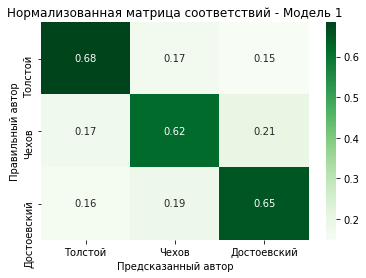

In [29]:
plot_confusion_matrix(confusion, classes=authors_names, \
                      normalize=True, title='Нормализованная матрица соответствий - Модель 1')

plt.savefig('confusion_model1.png')

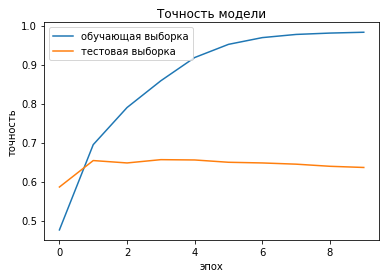

In [30]:
plot_history_of_accurancy(gram3_model_history)
plt.savefig('accurancy_model1.png')

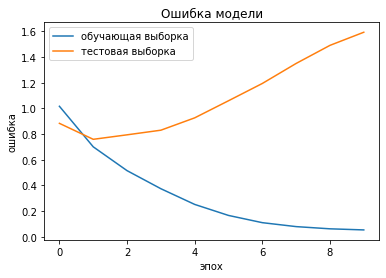

In [31]:
plot_history_of_loss(gram3_model_history)
plt.savefig('loss_model1.png')

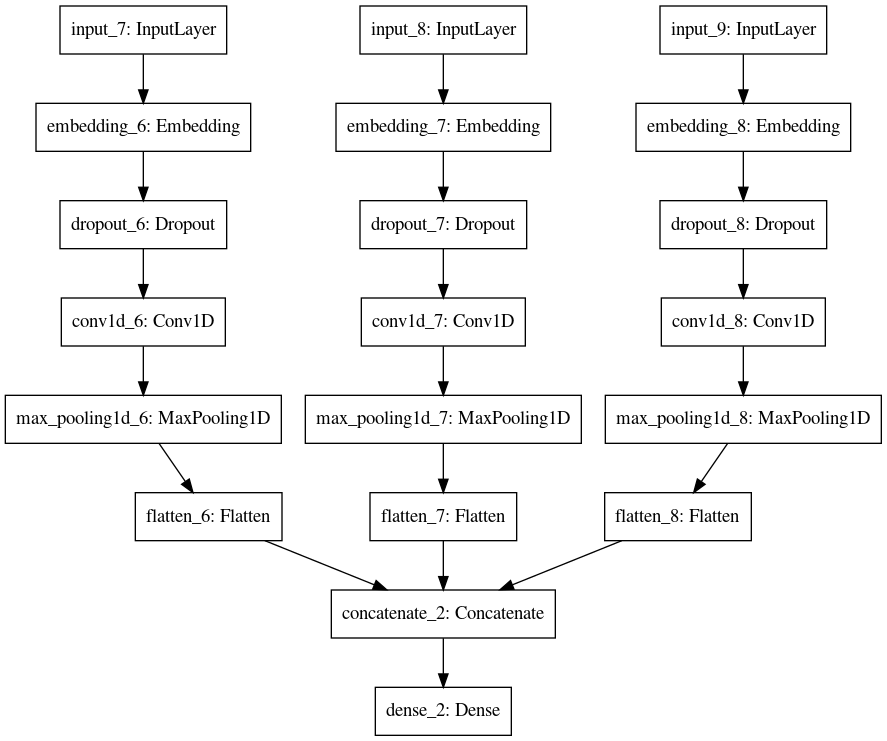

In [35]:
keras.utils.plot_model(gram3_model, 'gram3_model1_arh.png')

Лучшие результаты по точности показала триграммная модель, потому основной стоит выбрать её.

Улучшенную версию стоит обучать всего 5 эпох, т.к. на графике виден выход на плато и даже спад точности модели после этого момента.

### Усовершенствование

#### Добавление дополнительного канала CNN

Переобучение триграммной модели с добавлением дополнительного канала.

Ссылка: https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

In [32]:
def define_model2(input_len: int, output_size: int, vocab_size: int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size:int = 2, learning: float = 0.0001):
    
    # Канал 1
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    # Канал 2
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)

    # Канал 3
    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    # Канал 4
    inputs4 = Input(shape=(input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters=conv_filters, kernel_size=6, activation=activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size=pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    # Слияние каналов
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    # Создание выходного канала
    output = Dense(output_size, activation='softmax')(merged)
    
    # Создание модели
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    # И её компиляция
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

#### Триграммная модель

In [37]:
t0 = time.time()
gram3_model2 = define_model2(350, authors_count, max_3gram + 1, 600)

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           [(None, 350)]        0                                            
______________________________________________________________________________________

In [ ]:
gram3_model2_history = gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/5
 244/1080 [=====>........................] - ETA: 17:49 - loss: 1.0911 - accuracy: 0.3920

In [ ]:
author_pred2 = gram3_model2.predict([gram3_test, gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred2 = author_lb.inverse_transform(author_pred2)

# Расчёт статистики
accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support=score(author_test, author_pred2)
ave_precision = np.average(precision, weights=support/np.sum(support))
ave_recall = np.average(recall, weights=support/np.sum(support))
ave_f1 = np.average(f1, weights=support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels=authors_names)
    
print('Точность:', accuracy)
print('Средний Precision:', ave_precision)
print('Средний Recall:', ave_recall)
print('Средний F1 Score:', ave_f1)
print('Время обучения:', (t1 - t0), 'секунд')
print('Время предсказания:', (t2 - t1), 'секунд')
print('Матрица соответствий:\n', confusion)

In [ ]:
plot_confusion_matrix(confusion, classes=authors_names, \
                      normalize=True, title='Нормализованная матрица соответствий - Модель 2')

plt.savefig('confusion_model2.png')

In [ ]:
plot_history_of_accurancy(gram3_model2_history)
plt.savefig('accurancy_model2.png')

In [ ]:
plot_history_of_loss(gram3_model2_history)
plt.savefig('loss_model2.png')

In [ ]:
keras.utils.plot_model(gram3_model2, 'gram3_model2_arh.png')

### Анализ получившихся моделей

#### Бенчмарки, выбранные случайным образом тесты

In [ ]:
accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    author_pred3 = np.random.choice(authors_names, len(author_test))

    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print('Точность:', accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print('Средний Precision:', prec_list, np.mean(prec_list), np.std(prec_list))
print('Средний Recall:', recall_list, np.mean(recall_list), np.std(recall_list))
print('Средний F1 Score:', f1_list, np.mean(f1_list), np.std(f1_list))

**Исследование неправильно определённых предложений**

In [ ]:
for i in range(100):
    print('Предложение', i, '- Правильный ответ =', author_test[i],  'Модель 1 предсказала =', author_pred1[i], 
         'Модель 2 предсказала =', author_pred2[i])
    print(text_test[i], '\n')

In [ ]:
def calculate_averages(true, pred, text):
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    
    print('t-тест для символов')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nt-тест для слов')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [ ]:
# Calculate averages for Model 1
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(author_test, author_pred1, text_test)

In [ ]:
# Calculate averages for Model 2
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(author_test, author_pred2, text_test)

In [ ]:
print('Модель 1 - Средняя длина в символах правильно предсказанных предложений =', correct_ave_chars1, 
        ', неправильно предсказанных =', incorrect_ave_chars1)
print('Модель 2 - Средняя длина в символах правильно предсказанных предложений =', correct_ave_chars2, 
      ', неправильно предсказанных =', incorrect_ave_chars2)

print('\nМодель 1 - Средняя длина в словах правильно предсказанных предложений =', correct_ave_words1, 
        ', неправильно предсказанных =', incorrect_ave_words1)
print('Модель 2 - Средняя длина в словах правильно предсказанных предложений =', correct_ave_words2, 
      ', неправильно предсказанных =', incorrect_ave_words2)